# 微博平台社交行为预测分析
对于一条原创博文而言，转发，评论，点赞等互动行为能够体现出用户对于博文内容的兴趣程度，也是对博文进行分发控制的重要参考指标。本届赛题的任务就是根据抽样用户的原创博文在发表一天之后的转发，评论，赞总数，并预测用户后续博文在发表一天之后的互动情况。

微博的社交互动行为应该取决于三种因素：
1. 发布微博的用户特征，比如发表微博的平均社交次数，活跃时间等等
2. 微博中的形式化特征，比如发布时间，表情标签，@标签，#标签等
3. 微博中的非形式特征，比如语言风格，主题等等

由于原始数据基本上没有任何的特征，所以先做特征工程处理，然后再进行探索性数据分析，并基于这些分析结果来构造出更多的候选特征。

### 加载历史数据集

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re

train_data_path = 'data/weibo_train_data.txt'
test_data_path = 'data/weibo_predict_data.txt'

def read_history_data(data_path, columns):
    temp_data_list = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            temp_data_list.append(line.strip('\n').split('\t'))
    return pd.DataFrame(temp_data_list, columns=columns)

train_dataframe = read_history_data(train_data_path, columns=['用户id', '博文id', '时刻', '转发数量', '评论数量', '点赞数量', '博文内容'])
test_dataframe = read_history_data(test_data_path, columns=['用户id', '博文id', '时刻', '博文内容'])

训练集的样子如下：

In [2]:
train_dataframe.head()

,用户id,博文id,时刻,转发数量,评论数量,点赞数量,博文内容
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,看点不能说的，你们都懂[笑cry]
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,111多张


测试集的样子如下：

In [3]:
test_dataframe.head()

,用户id,博文id,时刻,博文内容
0,c01014739c046cd31d6f1b4fb71b440f,0cd5ef13eb11ed0070f7625b14136ec9,2015-08-19 22:44:55,Xah Emacs Tutorial http://t.cn/zWoY9IZ
1,fa5aed172c062c61e196eac61038a03b,7cce78a4ad39a91ec1f595bcc7fb5eba,2015-08-01 14:06:31,卖水果老人因没住处夜宿酒店门口 被车碾死 http://t.cn/RL0Hw8J （分享自@...
2,77fc723c196a45203e70f4d359c96946,a3494d8cf475a92739a2ffd421640ddf,2015-08-04 10:51:38,不要学习没有用的理论？ 不是：要学习，但要知道这个理论，为什么没有用？真实有用的理论是什么。...
3,e4097b07f34366399b623b94f174f60c,6b89aea5aa7af093dde0894156c49dd3,2015-08-16 14:59:19,[幸运之星] -恭喜！您的新浪微博账号已被系统确认为“新浪五周年”活动二等奖幸运用户。请登陆...
4,d43f7557c303b84070b13aa4eeeb21d3,0bdeff19392e15737775abab46dc5437,2015-08-04 22:30:46,【Lennart Poettering宣布首届Systemd会议】受争议Linux初始化系统...


In [4]:
# 将数据集拼接为总体数据集，统一进行特征工程处理，处理之后再分割为训练集和测试集
train_dataframe['转发数量'] = train_dataframe['转发数量'].astype(int)
train_dataframe['点赞数量'] = train_dataframe['点赞数量'].astype(int)
train_dataframe['评论数量'] = train_dataframe['评论数量'].astype(int)
total_dataframe = pd.concat([train_dataframe, test_dataframe], axis=0)
total_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407915 entries, 0 to 178296
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   用户id    1407915 non-null  object 
 1   博文id    1407915 non-null  object 
 2   时刻      1407915 non-null  object 
 3   转发数量    1229618 non-null  float64
 4   评论数量    1229618 non-null  float64
 5   点赞数量    1229618 non-null  float64
 6   博文内容    1407915 non-null  object 
dtypes: float64(3), object(4)
memory usage: 85.9+ MB


目前来看，数据集中没有空值和异常值。暂不进行处理。

# 抽取格式化特征
### 抽取样本的日期特征

In [5]:
total_feature_df = pd.DataFrame()
feature_columns = []

def insert_feature_tag(feature_name, feature_type):
    feature_tag = (feature_name, feature_type)
    if feature_tag not in feature_columns:
        feature_columns.append(feature_tag)

import datetime
clock_seq = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in total_dataframe['时刻']]
clock_seq_month = [i.month for i in clock_seq]
clock_seq_weekday = [i.weekday() for i in clock_seq]
clock_seq_day = [i.day for i in clock_seq]
clock_seq_hour = [i.hour for i in clock_seq]
clock_seq_minute = [i.minute for i in clock_seq]
clock_seq_minute_index = [i*60+j for i,j in zip(clock_seq_hour, clock_seq_minute)]
total_feature_df['月计数'] = clock_seq_month
insert_feature_tag('月计数', 'i')
total_feature_df['周计数'] = clock_seq_weekday
insert_feature_tag('周计数', 'i')
total_feature_df['日计数'] = clock_seq_day
insert_feature_tag('日计数', 'i')
total_feature_df['时计数'] = clock_seq_hour
insert_feature_tag('时计数', 'i')
total_feature_df['分计数'] = clock_seq_minute
insert_feature_tag('分计数', 'i')
total_feature_df['日内总分钟数'] = clock_seq_minute_index
insert_feature_tag('日内总分钟数', 'f')

### 抽取微博文本中的话题标签，用户标签，表情标签，超链接

In [6]:
def type_2_condition(content):
    pattern_1 = re.compile(r'向.*?@.*?提问')
    pattern_2 = re.compile(r'我在.*?提问')
    type_2_label = 0
    kernel_word_list = ['分享', '发表', '评论@', '评论给', '刚刚下载了豆丁文档', '通过@微盘 下载了',
                        '我刚刚下载了', '我刚下载了', '我刚才下载了', '我在#茶图素材网#下载了', '我正在关注',
                        '我上传了', '赞了 @', '我参与了']

    if pattern_1.findall(content) or pattern_2.findall(content):
        type_2_label = 1
    elif len(content) < 101:
        for kernel_word in kernel_word_list:
            if kernel_word in content[:20]:
                type_2_label = 1
    return type_2_label

# 话题的结构模式
pattern_topic = re.compile(r'#(.+?)#')
# 用户的结构模式
pattern_user = re.compile(r'@(.+?)[ ，@]')
# 表情的结构模式
pattern_face = re.compile(r'\[(.+?)\]')
# 超链接的结构模式
pattern_url = re.compile(r'http://t.cn/[a-zA-Z0-9]{7}')
# 超链接在最末尾的结构模式(在正则表达式中$代表文本的结束)
pattern_url_at_tail = re.compile(r'http://t.cn/[a-zA-Z0-9]{7}$')
# 标题的结构模式
pattern_title = re.compile(r'【.{6,}?】')

content_seq = total_dataframe['博文内容'].values
topic_tag_list = []
topic_tag_num_list = []
user_tag_list = []
user_tag_num_list = []
face_tag_list = []
face_tag_num_list = []
url_tag_list = []
url_at_tail_list = []
pic_tag_list = []
from_other_tag_list = []
uncomplete_tag_list = []
video_tag_list = []
auto_gene_tag_list = []
new_tag_list = []
is_computer_tag_list = []
is_stock_tag_list = []
is_promotion_tag_list = []
valid_content_len_list = []
valid_content_list = []
original_content_len_list = []
ppp_tag_list = []
for item_content in content_seq:
    # 话题标签
    topic_tag = pattern_topic.findall(item_content)
    topic_tag = [i for i in topic_tag if i.strip() != '']
    topic_tag_list.append(';'.join(topic_tag))
    topic_tag_num_list.append(len(topic_tag))
    # 用户标签
    user_tag = pattern_user.findall(item_content)
    user_tag = [i for i in user_tag if i.strip() != '']
    user_tag_list.append(';'.join(user_tag))
    user_tag_num_list.append(len(user_tag))
    # 表情标签
    face_tag = pattern_face.findall(item_content)
    face_tag = [i for i in face_tag if i.strip() != '']
    face_tag_list.append(';'.join(face_tag))
    face_tag_num_list.append(len(face_tag))
    # 文本中超链接的数量
    url_tag = pattern_url.findall(item_content)
    url_tag_list.append(len(url_tag))
    # 文本中超链接是否被放置在最末尾
    if pattern_url_at_tail.search(item_content):
        url_at_tail_list.append(1)
    else:
        url_at_tail_list.append(0)
    # 是否分享了图片
    if '分享图片' in item_content:
        pic_tag_list.append(1)
    else:
        pic_tag_list.append(0)
    # 该博文是否为转发
    item_mid_from_other = int('//' in item_content and 'http:' not in item_content)
    from_other_tag_list.append(item_mid_from_other)
    # 该博文是否未完全显示（没有完全显示的博文会在末尾区域有...，并辅导一个链接或者点击查看等文字）
    # 这样的博文本身是很长的，有一定的特殊性，所以需要记录下来。这里的30是假定未完全显示的博文...应该出现
    # 在倒数30个字符以内的位置。
    if '...' in item_content[-30:] and len(item_content) > 70:
        uncomplete_tag_list.append(1)
    else:
        uncomplete_tag_list.append(0)
    # 该博文是否插入视频，经过观察，微博中插入视频的样本通常都有“视频：”这样的格式
    if '视频：' in item_content:
        video_tag_list.append(1)
    else:
        video_tag_list.append(0)
    # 该博文是否为软件自动生成
    if type_2_condition(item_content):
        auto_gene_tag_list.append(1)
    else:
        auto_gene_tag_list.append(0)
    # 该博文中是否有标题，博文中标题通常有【xxx】这样的结构，有标题的博文通常是新闻报道类的
    if pattern_title.search(item_content):
        new_tag_list.append(1)
    else:
        new_tag_list.append(0)
    # 该博文的原始长度
    original_content_len_list.append(len(item_content))
    # 该博文中是否包含。。。这种特殊字符串
    if '。。。' in item_content:
        ppp_tag_list.append(1)
    else:
        ppp_tag_list.append(0)
    # 计算去掉格式化信息之后的博文长度
    item_content_strip = re.sub(r'#.+?#', '', item_content)
    item_content_strip = re.sub(r'http://t.cn/[0-9a-zA-Z]{7}', '', item_content_strip)
    item_content_strip = re.sub(r'（.*?@.*?）$', '', item_content_strip.strip())
    item_content_strip = re.sub(r'@.+?[ ，]', '', item_content_strip)
    item_content_strip = re.sub(r'\[.+?\]', '', item_content_strip)
    item_content_strip = re.sub(r'\(.*?\)$', '', item_content_strip)
    item_content_strip = re.sub(r'（.*?）$', '', item_content_strip)
    item_content_strip = re.sub(r'@.*?$', '', item_content_strip)
    valid_content_len_list.append(len(item_content_strip))
    valid_content_list.append(item_content_strip)
    # 对训练集的观察发现，与计算机相关的博文往往互动行为较多，所以可以通过一些关键词来判断该博文是否与计算机相关
    item_content_is_computer = 0 
    for keyword in ['Python', 'python', 'Java', 'java', 'JAVA', '计算机', '程序', '漏洞', '病毒',
                    '智能', '甲骨文', '谷歌', '微软', 'TensorFlow', 'PyTorch', 'Web', 'web', '云技术', '物联网',
                    'IT', '后端', '前端', '客户端', '科普', '硬件', '软件', '云计算', '开源', 'Git',
                    '代码', '框架', '算法', '版本', '科学', '数据挖掘', '数据库', '源码', 'bug', '数据分析', '服务器',
                   '互联网', 'Linux', '跨平台', 'CSS', 'SQL', '树莓派', '集群', '线程', '跨平台']:
        if keyword in item_content_strip:
            item_content_is_computer = 1
            break
    is_computer_tag_list.append(item_content_is_computer)
    # 微博中有大量荐股或者投资广告，所以这也是一类重要的博文，需要单独识别出来，我们也设定了一组关键词
    item_content_is_stock = 0
    for keyword in ['股票', '炒股', '理财', '投资', '盈利', '本金', '上证', '深证', '交易', '牛股', '指数',
                    '纳斯达克', '开盘', '收盘', '收益率', '股市', '套牢', '股神', '财经',
                    '宏观', '微观', '经济', '财报', '上市', '公司', '坐庄', '暴跌', '下跌', '股民', '投资者',
                   '成交量', '量能']:
        if keyword in item_content_strip:
            item_content_is_stock = 1
            break
    is_stock_tag_list.append(item_content_is_stock)
    # 微博中商业推广内容，所以这也是一类重要的博文，需要单独识别出来，我们也设定了一组关键词
    item_content_is_promotion = 0
    for keyword in ['红包', '转发', '推广', '点赞', '评论', '免费', '现金', '收藏', '广告', '签到', '福利', 'QQ群',
                    '专享', '小财神', '手气', '礼包', '券', '好运', '速来', '抽奖', '下载',
                     '查收', '领取', '打车', 'QQ：', 'wexin：', 'weixin：',
                   'QQ:', 'weixin:']:
        if keyword in item_content_strip:
            item_content_is_promotion = 1
            break
    is_promotion_tag_list.append(item_content_is_promotion)

column_name = '话题标签列表'
column_type = 'i'
total_feature_df[column_name] = topic_tag_list
insert_feature_tag(column_name, column_type)
column_name = '话题标签数量'
column_type = 'f'
total_feature_df[column_name] = topic_tag_num_list
insert_feature_tag(column_name, column_type)
column_name = '用户标签列表'
column_type = 'i'
total_feature_df[column_name] = user_tag_list
insert_feature_tag(column_name, column_type)
column_name = '用户标签数量'
column_type = 'f'
total_feature_df[column_name] = user_tag_num_list
insert_feature_tag(column_name, column_type)
column_name = '表情标签列表'
column_type = 'i'
total_feature_df[column_name] = face_tag_list
insert_feature_tag(column_name, column_type)
column_name = '表情标签数量'
column_type = 'f'
total_feature_df[column_name] = face_tag_num_list
insert_feature_tag(column_name, column_type)
column_name = '超链接标签数量'
column_type = 'f'
total_feature_df[column_name] = url_tag_list
insert_feature_tag(column_name, column_type)
column_name = '尾部超链接标记'
column_type = 'i'
total_feature_df[column_name] = url_at_tail_list
insert_feature_tag(column_name, column_type)
column_name = '图片标记'
column_type = 'i'
total_feature_df[column_name] = pic_tag_list
insert_feature_tag(column_name, column_type)
column_name = '转发标记'
column_type = 'i'
total_feature_df[column_name] = from_other_tag_list
insert_feature_tag(column_name, column_type)
column_name = '未完全显示标记'
column_type = 'i'
total_feature_df[column_name] = uncomplete_tag_list
insert_feature_tag(column_name, column_type)
column_name = '视频标记'
column_type = 'i'
total_feature_df[column_name] = video_tag_list
insert_feature_tag(column_name, column_type)
column_name = '自动生成标记'
column_type = 'i'
total_feature_df[column_name] = auto_gene_tag_list
insert_feature_tag(column_name, column_type)
column_name = '新闻标记'
column_type = 'i'
total_feature_df[column_name] = new_tag_list
insert_feature_tag(column_name, column_type)
column_name = '计算机标记'
column_type = 'i'
total_feature_df[column_name] = is_computer_tag_list
insert_feature_tag(column_name, column_type)
column_name = '股票标记'
column_type = 'i'
total_feature_df[column_name] = is_stock_tag_list
insert_feature_tag(column_name, column_type)
column_name = '推广标记'
column_type = 'i'
total_feature_df[column_name] = is_promotion_tag_list
insert_feature_tag(column_name, column_type)
column_name = '实际博文长度'
column_type = 'f'
total_feature_df[column_name] = valid_content_len_list
insert_feature_tag(column_name, column_type)
column_name = '截断博文内容'
column_type = 'i'
total_feature_df[column_name] = valid_content_list
insert_feature_tag(column_name, column_type)
column_name = '原始博文长度'
column_type = 'f'
total_feature_df[column_name] = original_content_len_list
insert_feature_tag(column_name, column_type)
column_name = '。。。标记'
column_type = 'i'
total_feature_df[column_name] = ppp_tag_list
insert_feature_tag(column_name, column_type)

In [7]:
total_feature_df.columns

Index(['月计数', '周计数', '日计数', '时计数', '分计数', '日内总分钟数', '话题标签列表', '话题标签数量',
       '用户标签列表', '用户标签数量', '表情标签列表', '表情标签数量', '超链接标签数量', '尾部超链接标记', '图片标记',
       '转发标记', '未完全显示标记', '视频标记', '自动生成标记', '新闻标记', '计算机标记', '股票标记', '推广标记',
       '实际博文长度', '截断博文内容', '原始博文长度', '。。。标记'],
      dtype='object')

In [8]:
# 增加一个实际博文长度与原始博文长度之间的比值指标
total_feature_df['有效博文占比'] = total_feature_df['实际博文长度'] / total_feature_df['原始博文长度']
insert_feature_tag('有效博文占比', 'f')
# 把用户ID列和三个社交指标附加在特征数据集上
total_feature_df['用户id'] = total_dataframe['用户id'].values
total_feature_df['转发数量'] = total_dataframe['转发数量'].values
total_feature_df['评论数量'] = total_dataframe['评论数量'].values
total_feature_df['点赞数量'] = total_dataframe['点赞数量'].values
# 因为测试集部分的社交指标为空值，所以丢弃掉
total_feature_df_ = total_feature_df.dropna()
# 将三个社交指标的类型转换为整型
total_feature_df_['转发数量'] = total_feature_df_['转发数量'].astype(int)
total_feature_df_['评论数量'] = total_feature_df_['评论数量'].astype(int)
total_feature_df_['点赞数量'] = total_feature_df_['点赞数量'].astype(int)
total_feature_df_['实际博文长度分桶'] = pd.qcut(total_feature_df_['实际博文长度'], q=10, 
                                        labels=['博文长度排序分组_%d' % i for i in range(10)])
total_feature_df_['原始博文长度分桶'] = pd.qcut(total_feature_df_['原始博文长度'], q=10, 
                                        labels=['原始博文长度排序分组_%d' % i for i in range(10)])
total_feature_df_['有效博文占比分桶'] = pd.cut(total_feature_df_['有效博文占比'], bins=np.linspace(0, 1, 10), 
                                        labels=['有效博文占比排序分组_%d' % i for i in range(9)]
                                      )

D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
D:\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [9]:
# 打印出每一种特征不同取值对应的目标量平均值和相应的样本量
# 平均值的差异反映了该特征对于目标量的变化有多大的影响，而样本量的多与少则可以反映平均值统计量的可靠程度
# 基于越多样本计算出来的平均值约可靠。

for cate_feature_name in ['周计数', '时计数', '分计数', '话题标签数量', '用户标签数量', '表情标签数量', '超链接标签数量',
                         '尾部超链接标记', '图片标记', '转发标记', '未完全显示标记', '视频标记', '自动生成标记', '新闻标记',
                         '计算机标记', '股票标记', '推广标记', '实际博文长度分桶', '原始博文长度分桶', '。。。标记', '有效博文占比分桶']:
    #cate_feature_name = '尾部超链接标记'
    target_feature_name = ['转发数量', "评论数量", '点赞数量']
    print(pd.concat([total_feature_df_.groupby(cate_feature_name)[target_feature_name].mean(),
               total_feature_df_.groupby(cate_feature_name)['用户id'].count()],
              axis=1))

         转发数量      评论数量      点赞数量    用户id
周计数                                      
0    3.496040  1.189901  2.031954  180447
1    3.755973  1.291836  2.082722  186807
2    3.273270  1.203897  2.020607  199934
3    3.733299  1.297440  2.148647  192005
4    3.299649  1.276671  2.184628  180124
5    3.524528  1.278953  2.696688  144551
6    3.714662  1.267273  2.531842  145750
         转发数量      评论数量      点赞数量   用户id
时计数                                     
0    1.613041  1.223602  2.158050  48801
1    1.353306  0.955282  1.694427  23883
2    1.258799  0.858715  1.885801  14177
3    1.512349  0.768129  1.595436  10122
4    1.129332  0.570102  0.853114   8830
5    3.718750  0.811062  1.380847  10432
6    2.907210  0.794642  1.157576  19819
7    2.246653  0.711745  1.187576  35479
8    3.216602  0.890096  1.637298  60835
9    4.837037  1.187478  2.306828  77545
10   3.253302  1.108870  1.589376  77974
11   4.756730  1.452645  2.323658  73108
12   4.390888  1.300584  2.494867  63320
13   3.

               转发数量       评论数量        点赞数量    用户id
超链接标签数量                                           
0          4.573256   2.234719    3.956596  474244
1          2.567478   0.606738    1.077793  719073
2          7.820601   1.223086    1.701812   33328
3         18.532461   2.315048    3.672370    1987
4         14.653451   1.763583    3.844347     681
5         47.041026   4.994872    8.528205     195
6         43.622222   6.644444   12.022222      45
7        118.095238  10.904762   39.785714      42
8        710.071429  65.642857  186.428571      14
9         82.250000  10.000000   13.000000       4
10        13.250000   1.000000    4.750000       4
11        64.000000  42.000000    2.000000       1
             转发数量      评论数量      点赞数量    用户id
尾部超链接标记                                      
0        4.570790  1.961938  3.457155  598784
1        2.555439  0.587498  1.037525  630834
          转发数量      评论数量      点赞数量     用户id
图片标记                                       
0     3.559819

观察各个特征不同取值与转发数量平均值及样本数量之间的关系，可以发现：

“周计数”这一指标对于转发数量是没有任何影响的，也就是说你在周几去发布这一博文对于转发数量没有影响。但“周计数”这一指标对点赞数量有一些影响，即周末的发布点赞数量会更多一些。

“时计数”上显然有明显的差异，所以它是有力的预测指标。

“分计数”是每一条博文发布时刻中的分钟数，从常识来看，应该对于社交行为是没有影响的，但是统计结果发现，这个指标居然有这么显著的影响。

“话题标签数量”指标上数值主要集中于0,1,2,3这四种情况，博文中有两个话题标签是最容易触发社交行为的，而有1个话题标签是最不利于触发社交行为的。

“用户标签数量”指标上，样本主要集中于0,1,2,3这四种情况上，显然只涉及到一个用户的博文是最不好的，而涉及到2个及以上的博文是比较受欢迎的。

“表情标签数量”这一指标上，样本主要集中于0,1,2,3,4这五种情况上，显然博文中包含1,2,3个表情的时候最受欢迎。

“超链接标签数量”这一指标上，样本主要集中于0,1,2三种情况，显然超链接数量为1的情况下社交互动比较少，而超链接数量为0或者2的情况下，社交互动会明显增多。

“尾部超链接标记”这一指标上，显然尾部没有超链接的情况转发数量会比较多。

在“图片标记”这一指标上，只要不太多的样本中包含图片，这部分样本得到的社交互动数量较少。

“转发标记”这一指标上，只有很少量的样本是属于转发类样本的，这一部分样本会得到更多的社交互动。

“未完全显示标记”这一指标上，约有5%的样本属于未完全显示的，这一部分样本显然没有得到更多的社交互动。

“视频标记”这一个指标上，约有1%的样本属于插入视频的，这一部分样本显然没有得到更多的社交互动。

“自动生成标记”这一指标上，约有7%的样本属于自动生成的，自动生成的样本会得到更多的转发，更少的评论和更多的点赞。这也是符合常识的。

“新闻标记”这一指标中，约有18%的样本属于新闻类，这一部分样本显然会得到更多的转发，而评论数量会有所下降，点赞数量波动较小。

“计算机标记”这一指标中，约有19%的样本属于计算机相关类博文，这一部分样本会得到更多的转发，而对其他指标没有啥影响。

“股票标记”这一指标中，约有6%的样本属于股票相关类博文，这一部分样本会得到更少的社交互动行为。

“推广标记”这一指标中，约有17%的样本属于推广相关类博文，这一部分样本会得到更多的转发，以及更少的点赞和评论。

“实际博文长度”这一指标中，实际博文字数越多，社交互动数量就相对更多。

“原始博文长度”这一指标中，只有原始博文长度特别长的时候，社交互动数量就会很多。

“。。。标记”这一指标中，出现。。。标记的博文占比为2%左右，出现这个标记的博文社交互动数量会有微量的增加，特别是在评论数量上，会有翻倍的效果。

### 识别关键用户，话题与表情
由于部分话题是某一时期内的热点，所以通常会获得更多的社交互动。我们在这里统计出不同话题对应的社交互动数量，以此来挑选出一部分具有预测能力的话题。

In [10]:
tag_stats_map = {}
for i_tags, i_forward_n, i_comment_n, i_up_n in total_feature_df[['话题标签列表', '转发数量', '评论数量', '点赞数量']].values:
    i_total_social_n = i_forward_n + i_comment_n + i_up_n
    if np.isnan(i_total_social_n):
        continue
    for i_tag in i_tags.split(';'):
        if i_tag not in tag_stats_map:
            tag_stats_map[i_tag] = []
        tag_stats_map[i_tag].append(i_total_social_n)
tag_stats_map_aver = [[k, np.mean(v), len(v)] for k, v in tag_stats_map.items() if len(v) > 1000]
sorted_tag_stats = sorted(tag_stats_map_aver, key=lambda i: i[1])
sorted_tag_stats

[['IT', 0.025099627201439774, 31116],
 ['微博等级专享礼', 0.028516746411483253, 5225],
 ['快的打车，就摇快乐', 0.03517241379310345, 1450],
 ['快的打车代金券', 0.049788214312253845, 13457],
 ['科技', 0.05179110919292188, 2317],
 ['快的打车', 0.05956977385548814, 1813],
 ['天猫年中大促', 0.0967098703888335, 1003],
 ['微盘签到', 0.10111960191931757, 5627],
 ['扇贝打卡', 0.1232876712328767, 7154],
 ['春晚', 0.143281917859134, 5381],
 ['百词斩学霸认证', 0.17382906808305165, 2071],
 ['稀酷客(随书光盘)', 0.18873239436619718, 1420],
 ['百词斩', 0.18915343915343916, 2268],
 ['微盘', 0.37647521636506687, 5084],
 ['亚洲新歌榜', 0.4903786468032278, 3222],
 ['财经', 0.614307931570762, 1286],
 ['投资', 0.6979038224414303, 1622],
 ['理财', 0.6983343615052436, 1621],
 ['随手拍', 0.7700490998363339, 1222],
 ['NLP Job', 0.776536312849162, 2864],
 ['股神', 0.9318336741649625, 1467],
 ['炒股', 0.932140653917335, 1621],
 ['股市', 1.0149355057705363, 1473],
 ['股票', 1.08982748364069, 1681],
 ['克拉男神郑智薰', 3.2596248766041462, 3039],
 ['逗比总裁萧亮', 4.648809523809524, 3024],
 ['美拍', 6.3490364025695

既然要挑选一个具有预测性的话题标签，那么这个话题就应该具有一定程度的常见性，所以这里设定话题出现的次数不低于3000次。将满足这一要求的话题标签进行排序，就得到了上面的结果。显然“IT，微博等级专享礼，快的打车代金券，微盘签到，扇贝打卡，春晚，微盘，亚洲新歌榜”这几个标签属于低社交互动的标签，而“湾区日报，早安心语，rain克拉恋人，RAIN-JIHOON”属于高社交互动的标签。

同理，对用户标签和表情标签也做同样的处理，得到如下结果：

In [11]:
tag_stats_map = {}
for i_tags, i_forward_n, i_comment_n, i_up_n in total_feature_df[['用户标签列表', '转发数量', '评论数量', '点赞数量']].values:
    i_total_social_n = i_forward_n + i_comment_n + i_up_n
    if np.isnan(i_total_social_n):
        continue
    for i_tag in i_tags.split(';'):
        if i_tag not in tag_stats_map:
            tag_stats_map[i_tag] = []
        tag_stats_map[i_tag].append(i_total_social_n)
tag_stats_map_aver = [[k, np.mean(v), len(v)] for k, v in tag_stats_map.items() if len(v) > 1000]
sorted_tag_stats = sorted(tag_stats_map_aver, key=lambda i: i[1])
sorted_tag_stats

[['格瓦拉生活网', 0.0074487895716946, 1074],
 ['51CTO学院）', 0.03049645390070922, 1410],
 ['掌阅iReader', 0.03622540250447227, 2236],
 ['微彩票', 0.057126696832579184, 1768],
 ['快的打车', 0.05865177748181539, 19522],
 ['Weico微博客户端', 0.0616357171078625, 5062],
 ['fangshimin', 0.06589673913043478, 2944],
 ['让红包飞', 0.0864575363427697, 1307],
 ['支付宝钱包', 0.0893371757925072, 11798],
 ['郑州大学水利与环境学院团委', 0.1107172075265885, 3667],
 ['微盘', 0.2606568832983927, 7155],
 ['天猫', 0.29063604240282687, 1132],
 ['今日头条', 1.099639855942377, 1666],
 ['优酷）', 1.5516080777860883, 2674],
 ['优酷', 1.8903150525087515, 1714],
 ['知乎日报', 2.3685550604710377, 1571],
 ['电视剧-克拉恋人', 2.634534394010295, 2137],
 ['RAIN-JIHOON', 3.742216777169213, 13876],
 ['知乎', 3.9968012794882046, 5002],
 ['', 7.490123969033042, 988150],
 ['SegmentFault', 8.626101321585903, 1816]]

In [12]:
tag_stats_map = {}
for i_tags, i_forward_n, i_comment_n, i_up_n in total_feature_df[['表情标签列表', '转发数量', '评论数量', '点赞数量']].values:
    i_total_social_n = i_forward_n + i_comment_n + i_up_n
    if np.isnan(i_total_social_n):
        continue
    for i_tag in i_tags.split(';'):
        if i_tag not in tag_stats_map:
            tag_stats_map[i_tag] = []
        tag_stats_map[i_tag].append(i_total_social_n)
tag_stats_map_aver = [[k, np.mean(v), len(v)] for k, v in tag_stats_map.items() if len(v) > 1000]
sorted_tag_stats = sorted(tag_stats_map_aver, key=lambda i: i[1])
sorted_tag_stats

[['iso', 0.1608187134502924, 1710],
 ['转载', 0.16682926829268294, 2050],
 ['推荐', 1.2746121103940684, 7283],
 ['发红包', 2.6695254431103486, 10494],
 ['好棒', 2.8460176991150443, 1130],
 ['生病', 4.60377358490566, 2968],
 ['太开心', 5.078024941017863, 5934],
 ['晕', 5.24375, 1280],
 ['哼', 5.749118683901292, 1702],
 ['挖鼻屎', 6.038513210927004, 2233],
 ['太阳', 6.156791248860529, 1097],
 ['', 6.335240241406514, 1068571],
 ['怒', 6.391879562043796, 2192],
 ['泪流满面', 6.480600750938673, 1598],
 ['蜡烛', 6.534804753820034, 1767],
 ['噢耶', 7.321566110397946, 1558],
 ['馋嘴', 7.653876898481215, 1251],
 ['害羞', 7.907852564102564, 2496],
 ['呵呵', 8.090686274509803, 2040],
 ['微风', 8.502472799208704, 1011],
 ['喵喵', 9.044929396662388, 3116],
 ['可爱', 9.564336775218427, 2518],
 ['挖鼻', 10.079141515761235, 1491],
 ['礼物', 10.312896922325354, 8188],
 ['思考', 10.41676891615542, 2445],
 ['鼓掌', 10.622355541521944, 3167],
 ['阴险', 10.641481481481481, 1350],
 ['good', 12.330844155844156, 3080],
 ['衰', 12.771297278190174, 2829],
 ['话筒',

从统计结果来看，用户中低社交互动的有“快的打车，Weico微博客户端，支付宝钱包，郑州大学水利与环境学院团委，微盘”，高社交互动的没有。表情标签中低社交互动的有“推荐，发红包”，而高社交互动的有“喵喵，礼物，鼓掌，good，偷笑，泪，笑cry，嘻嘻，爱你，哈哈，心，doge，抓狂，拜拜”。基于这些结果，我们向特征集中增加相应的标签。

In [13]:
topic_low_value_list = 'IT，微博等级专享礼，快的打车代金券，微盘签到，扇贝打卡，春晚，微盘，亚洲新歌榜，快的打车，科技，天猫年中大促，百词斩学霸认证，稀酷客(随书光盘)，百词斩，财经，投资，理财，随手拍，NLP Job，股神，炒股，股市，股票'.split('，')
topic_high_value_list = '湾区日报，早安心语，rain克拉恋人，RAIN-JIHOON，武汉分享，技术分享，RAIN郑智薰出道13周年，Rain'.split('，')
user_low_value_list = '快的打车，Weico微博客户端，支付宝钱包，郑州大学水利与环境学院团委，微盘，格瓦拉生活网，51CTO学院），掌阅iReader，微彩票，fangshimin，让红包飞，天猫，今日头条，优酷，知乎日报，电视剧-克拉恋人'.split('，')
face_low_value_list = '推荐，发红包，iso，转载，好棒'.split('，')
face_high_value_list = '喵喵，礼物，鼓掌，good，偷笑，泪，笑cry，嘻嘻，爱你，哈哈，心，doge，抓狂，拜拜，挖鼻，思考，阴险，衰，话筒，得意地笑，酷，月亮，吃惊，偷乐，微笑，汗，围观，耶，怒骂，给力，色，花心，赞，威武，挤眼，悲伤，可怜'.split('，')

def gene_tag_value_list(column_name, tag_list):
    column_data = total_feature_df[column_name].values
    tag_value_list = []
    for i in column_data:
        label = 0
        for j in tag_list:
            if j in i:
                label = 1
                break
        tag_value_list.append(label)
    return tag_value_list

total_feature_df['低价值话题标签'] = gene_tag_value_list('话题标签列表', topic_low_value_list)
total_feature_df['高价值话题标签'] = gene_tag_value_list('话题标签列表', topic_high_value_list)
total_feature_df['低价值用户标签'] = gene_tag_value_list('用户标签列表', user_low_value_list)
total_feature_df['低价值表情标签'] = gene_tag_value_list('表情标签列表', face_low_value_list)
total_feature_df['高价值表情标签'] = gene_tag_value_list('表情标签列表', face_high_value_list)
column_name = '低价值话题标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '高价值话题标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '低价值用户标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '低价值表情标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)
column_name = '高价值表情标签'
column_type = 'i'
insert_feature_tag(column_name, column_type)

In [14]:
for cate_feature_name in ['低价值话题标签', '高价值话题标签', '低价值用户标签', '低价值表情标签', '高价值表情标签']:
    target_feature_name = ['转发数量', "评论数量", '点赞数量']
    print(pd.concat([total_feature_df.groupby(cate_feature_name)[target_feature_name].mean(),
               total_feature_df.groupby(cate_feature_name)['用户id'].count()],
              axis=1))

             转发数量      评论数量      点赞数量     用户id
低价值话题标签                                       
0        3.808067  1.356196  2.387750  1301529
1        0.388808  0.103174  0.220036   106386
             转发数量      评论数量      点赞数量     用户id
高价值话题标签                                       
0        3.484414  1.257699  2.150187  1381058
1        6.849181  1.200397  6.360923    26857
             转发数量      评论数量      点赞数量     用户id
低价值用户标签                                       
0        3.739876  1.328711  2.339001  1335415
1        0.157559  0.059967  0.165280    72500
             转发数量      评论数量      点赞数量     用户id
低价值表情标签                                       
0        3.589116  1.275794  2.247059  1385310
1        0.473995  0.144104  0.384373    22605
             转发数量     评论数量      点赞数量     用户id
高价值表情标签                                      
0        3.274677  1.09928  1.959785  1294742
1        6.541492  3.06214  5.149948   113173


另外，我们观察这些出现次数超过1000次的话题，用户，表情等，有几个要不出现次数特别多同时相应的社交互动明显偏离平均值，要不相应的社交互动数量远远偏离平均值。我们也把这一些特征作为模型特征之一。

In [15]:
total_feature_df['话题-IT'] = [1 if 'IT' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-快的打车'] = [1 if '快的打车' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-RAIN-JIHOON'] = [1 if 'RAIN-JIHOON' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-Rain'] = [1 if 'Rain' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-科技'] = [1 if '科技' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-扇贝打卡'] = [1 if '扇贝打卡' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-百词斩'] = [1 if '百词斩' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['话题-微盘签到'] = [1 if '微盘签到' in i else 0 for i in total_feature_df['话题标签列表']]
total_feature_df['用户-快的打车'] = [1 if '快的打车' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['用户-支付宝钱包'] = [1 if '支付宝钱包' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['用户-RAIN-JIHOON'] = [1 if 'RAIN-JIHOON' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['用户-掌阅iReader'] = [1 if '掌阅iReader' in i else 0 for i in total_feature_df['用户标签列表']]
total_feature_df['表情-发红包'] = [1 if '发红包' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-泪'] = [1 if '泪' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-笑cry'] = [1 if '笑cry' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-哈哈'] = [1 if '哈哈' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-心'] = [1 if '心' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-doge'] = [1 if 'doge' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-悲伤'] = [1 if '悲伤' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-拜拜'] = [1 if '拜拜' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-可怜'] = [1 if '可怜' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-iso'] = [1 if 'iso' in i else 0 for i in total_feature_df['表情标签列表']]
total_feature_df['表情-转载'] = [1 if '转载' in i else 0 for i in total_feature_df['表情标签列表']]

single_tag_features = '话题-IT，话题-快的打车，话题-RAIN-JIHOON，话题-Rain，话题-科技，话题-扇贝打卡，话题-百词斩，话题-微盘签到，' + \
                        '用户-快的打车，用户-支付宝钱包，用户-RAIN-JIHOON，用户-掌阅iReader，表情-发红包，表情-泪，表情-笑cry，' + \
                        '表情-哈哈，表情-心，表情-doge，表情-悲伤，表情-拜拜，表情-可怜，表情-iso，表情-转载'
single_tag_features = single_tag_features.split('，')
for tag_feature in single_tag_features:
    insert_feature_tag(tag_feature, 'i')

### 用户属性特征
上面的工作完成了对每一条博文的文本特征抽取，而由于社交网络的存在，同样的博文由不同的用户发布所能够获得的互动行为是迥然不同的。所以需要统计出不同用户的特征以辅助对每一条博文进行预测。

In [16]:
uid_feature_df = total_feature_df.groupby('用户id')
uid_feature_map = {}
for uid, uid_df in uid_feature_df:
    uid_feature = []
    # 该用户所发布博文的数量
    uid_content_num = len(uid_df)
    # 该用户所发布博文中的最大转发数量
    uid_forward_max = uid_df['转发数量'].max()
    if np.isnan(uid_forward_max):
        uid_forward_max = 0
    # 该用户所发布博文中的平均转发数量
    uid_forward_mean = uid_df['转发数量'].mean()
    if np.isnan(uid_forward_mean):
        uid_forward_mean = 0
    # 该用户所发布博文中的转发数量标准差
    uid_forward_std = uid_df['转发数量'].std()
    if np.isnan(uid_forward_std):
        uid_forward_std = 0
        
    # 该用户所发布博文中的最大评论数量
    uid_comment_max = uid_df['评论数量'].max()
    if np.isnan(uid_comment_max):
        uid_comment_max = 0
    # 该用户所发布博文中的平均评论数量
    uid_comment_mean = uid_df['评论数量'].mean()
    if np.isnan(uid_comment_mean):
        uid_comment_mean = 0
    # 该用户所发布博文中的评论数量标准差
    uid_comment_std = uid_df['评论数量'].std()
    if np.isnan(uid_comment_std):
        uid_comment_std = 0
        
    # 该用户所发布的博文中的最大点赞数量
    uid_up_max = uid_df['点赞数量'].max()
    if np.isnan(uid_up_max):
        uid_up_max = 0
    # 该用户所发布的博文中的平均点赞数量
    uid_up_mean = uid_df['点赞数量'].mean()
    if np.isnan(uid_up_mean):
        uid_up_mean = 0
    # 该用户所发布博文中的点赞数量标准差
    uid_up_std = uid_df['点赞数量'].std()
    if np.isnan(uid_up_std):
        uid_up_std = 0
            
    
    # 平均话题标签数量，表情标签数量，用户标签数量，超链接标签数量等指标
    temp_features = '日内总分钟数，话题标签数量，用户标签数量，表情标签数量，超链接标签数量，尾部超链接标记，新闻标记，' + \
                    '计算机标记，推广标记，实际博文长度，原始博文长度，有效博文占比'
    temp_features = temp_features.split('，')
    uid_other_avers = [uid_df[feature].mean() for feature in temp_features]
    uid_feature_map[uid] = [uid_content_num, uid_forward_max, uid_forward_mean, uid_forward_std, uid_comment_max, uid_comment_mean, 
                            uid_comment_std, uid_up_max, uid_up_mean, uid_up_std] + uid_other_avers

In [17]:
temp_features = '总博文数量，最大转发数量，平均转发数量，标准差转发数量，最大评论数量，平均评论数量，标准差评论数量，' + \
            '最大点赞数量，平均点赞数量，标准差点赞数量，' + \
            '日内总分钟数，话题标签数量，用户标签数量，表情标签数量，超链接标签数量，尾部超链接标记，新闻标记，' + \
                    '计算机标记，推广标记，实际博文长度，原始博文长度，有效博文占比'
temp_features = ['用户-%s' % i for i in temp_features.split('，')]
uid_feature_array = [[i] + j for i,j in uid_feature_map.items()]
uid_feature_df = pd.DataFrame(uid_feature_array, columns=['用户id'] + temp_features)

In [18]:
uid_feature_df[uid_feature_df['用户-总博文数量'] > 100].head(10)

,用户id,用户-总博文数量,用户-最大转发数量,用户-平均转发数量,用户-标准差转发数量,用户-最大评论数量,用户-平均评论数量,用户-标准差评论数量,用户-最大点赞数量,用户-平均点赞数量,...,用户-用户标签数量,用户-表情标签数量,用户-超链接标签数量,用户-尾部超链接标记,用户-新闻标记,用户-计算机标记,用户-推广标记,用户-实际博文长度,用户-原始博文长度,用户-有效博文占比
4,000c663a24a2f91f4ba156fcd4f8b9f2,133,1.0,0.016393,0.127507,7.0,0.270492,0.927423,6.0,0.393443,...,0.075188,0.563910,0.263158,0.225564,0.045113,0.015038,0.030075,26.834586,35.436090,0.704489
14,001e00fddab72bf7e6be3455e199904a,452,1.0,0.004890,0.069843,2.0,0.007335,0.110458,1.0,0.014670,...,0.440265,0.011062,0.836283,0.734513,0.185841,0.378319,0.068584,51.511062,74.601770,0.626414
31,00366f1ae39b881bdb2ba8687a4c912a,200,0.0,0.000000,0.000000,0.0,0.000000,0.000000,3.0,0.093567,...,0.005000,0.015000,0.990000,0.990000,0.000000,0.000000,0.005000,23.915000,50.720000,0.463703
48,005401d2c80b0df8622baf3863f6ebd1,176,5.0,0.098684,0.498473,8.0,1.230263,1.913599,6.0,0.664474,...,0.136364,0.244318,0.369318,0.295455,0.028409,0.034091,0.090909,33.653409,46.227273,0.764605
50,005956e5440af20d49160cc6b4c3f7c8,175,2.0,0.058065,0.284644,3.0,0.032258,0.265295,3.0,0.038710,...,0.011429,0.017143,0.994286,0.005714,0.005714,0.217143,0.000000,23.325714,42.725714,0.510371
67,007a38e5a32453796a9725ff216531de,112,2.0,0.255102,0.523888,3.0,0.346939,0.659616,4.0,0.285714,...,0.017857,0.223214,0.830357,0.214286,0.008929,0.035714,0.008929,47.276786,65.392857,0.627894
79,008ae13aeeeb93aae3989160052ac874,201,19.0,0.933735,2.194029,21.0,2.795181,3.048135,35.0,7.518072,...,0.059701,0.004975,0.144279,0.139303,0.004975,0.014925,0.024876,49.870647,53.268657,0.945537
127,00f9d3589fe229108ba4d5216000a966,115,37.0,0.783333,4.812032,23.0,3.050000,5.286455,6.0,1.050000,...,0.704348,1.408696,0.773913,0.313043,0.000000,0.017391,0.608696,43.156522,80.243478,0.564583
182,0155039f54852497fc4b9d858f113ad1,180,2.0,0.021739,0.208514,1.0,0.021739,0.146630,12.0,0.456522,...,0.977778,0.055556,0.483333,0.433333,0.022222,0.000000,0.016667,46.611111,94.066667,0.496817
184,0158b3e9d30bdc48cc445710a6afa651,636,3.0,0.011058,0.142993,1.0,0.001580,0.039746,1.0,0.009479,...,0.094340,0.067610,0.496855,0.487421,0.410377,0.026730,0.051887,34.215409,45.133648,0.845636


In [19]:
concat_feature_df = pd.merge(left=total_feature_df, right=uid_feature_df, 
                             on='用户id', how='left')
concat_feature_df.iloc[10]

月计数                  2
周计数                  2
日计数                 11
时计数                 19
分计数                 29
               ...    
用户-计算机标记      0.355556
用户-推广标记      0.0444444
用户-实际博文长度      80.3444
用户-原始博文长度      106.811
用户-有效博文占比     0.782136
Name: 10, Length: 82, dtype: object

In [20]:
concat_columns = feature_columns + [(i, 'f') for i in temp_features] + [('用户id', 'i')]
# 被选为建模特征的列表
selected_features = '周计数，时计数，分计数，日内总分钟数，话题标签数量，用户标签数量，表情标签数量，超链接标签数量，尾部超链接标记，'+\
                    '图片标记，转发标记，未完全显示标记，视频标记，自动生成标记，新闻标记，计算机标记，股票标记，推广标记，实际博文长度'+\
                    '，原始博文长度，。。。标记，有效博文占比，低价值话题标签，高价值话题标签，低价值用户标签，低价值表情标签，高价值表情标签，'+\
                    '用户-总博文数量，用户-最大转发数量，用户-平均转发数量，用户-标准差转发数量，用户-最大评论数量，'+\
                    '用户-平均评论数量，用户-标准差评论数量，用户-最大点赞数量，用户-平均点赞数量，用户-标准差点赞数量，' + \
                    '用户-日内总分钟数，用户-话题标签数量，用户-用户标签数量'+\
                    '用户-表情标签数量，用户-超链接标签数量，用户-尾部超链接标记，用户-新闻标记，用户-计算机标记，用户-推广标记，' +\
                    '用户-实际博文长度，用户-原始博文长度，用户-有效博文占比，用户id' + \
                    '话题-IT，话题-快的打车，话题-RAIN-JIHOON，话题-Rain，话题-科技，话题-扇贝打卡，话题-百词斩，话题-微盘签到，' + \
                    '用户-快的打车，用户-支付宝钱包，用户-RAIN-JIHOON，用户-掌阅iReader，表情-发红包，表情-泪，表情-笑cry，' + \
                    '表情-哈哈，表情-心，表情-doge，表情-悲伤，表情-拜拜，表情-可怜，表情-iso，表情-转载'
selected_features = [i for i in concat_columns if i[0] in selected_features.split('，')]
# 把特征分为离散型特征和连续型特征
cate_features = [i[0] for i in selected_features if i[1] == 'i']
conti_features = [i[0] for i in selected_features if i[1] == 'f']

### 目标变量的基本特征

Text(0.5, 1.0, '点赞数量')

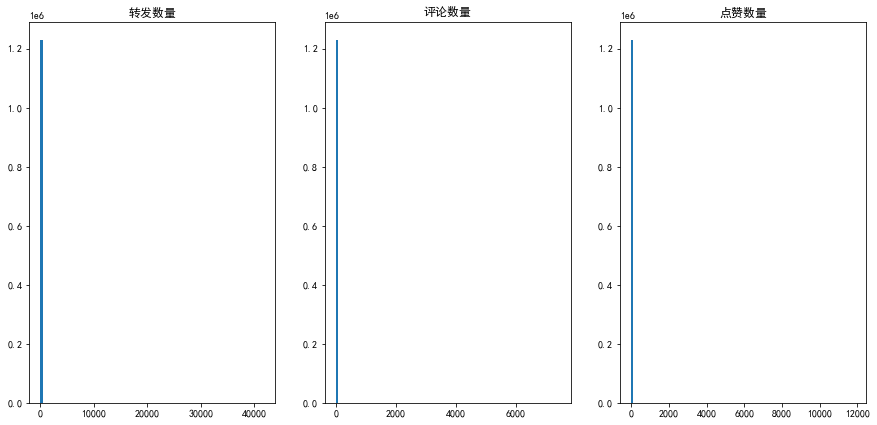

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #解决中文显示
plt.rcParams['axes.unicode_minus'] = False #解决符号无法显示

figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(131)
_ = plt.hist(train_dataframe['转发数量'].values, bins=100)
plt.title('转发数量')
ax = figure.add_subplot(132)
_ = plt.hist(train_dataframe['评论数量'].values, bins=100)
plt.title('评论数量')
ax = figure.add_subplot(133)
_ = plt.hist(train_dataframe['点赞数量'].values, bins=100)
plt.title('点赞数量')

显然由于大量的博文没有任何的互动行为，所以，这些目标量集中于0。对于这种严重长尾分布的情况，我们应该进行一次对数变换，看看结果如何。

Text(0.5, 1.0, '点赞数量')

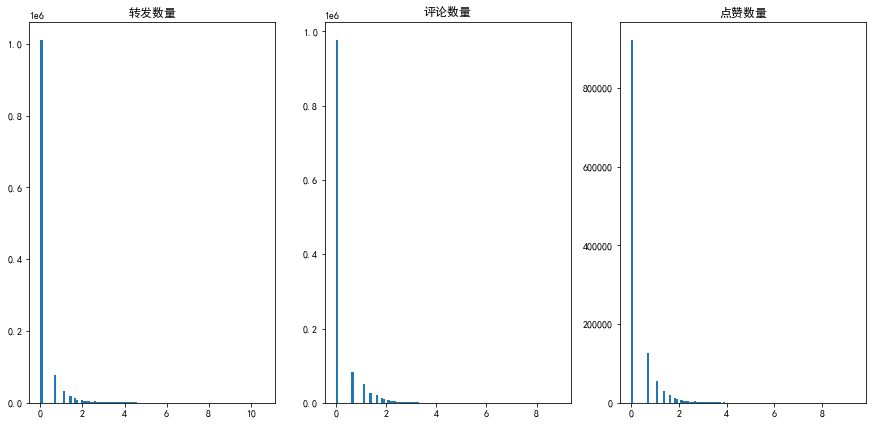

In [22]:
figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(131)
_ = plt.hist(np.log(train_dataframe['转发数量'].values+1), bins=100)
plt.title('转发数量')
ax = figure.add_subplot(132)
_ = plt.hist(np.log(train_dataframe['评论数量'].values+1), bins=100)
plt.title('评论数量')
ax = figure.add_subplot(133)
_ = plt.hist(np.log(train_dataframe['点赞数量'].values+1), bins=100)
plt.title('点赞数量')

显然进行一次对数变换之后，数据分布情况依然呈现为对数正态分布，所以要再进行一次对数变换。

Text(0.5, 1.0, '点赞数量')

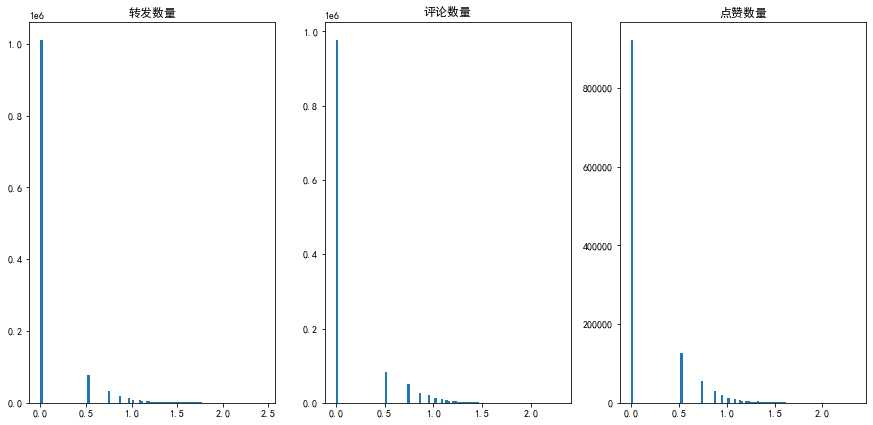

In [23]:
figure = plt.figure(figsize=(15, 7))
ax = figure.add_subplot(131)
_ = plt.hist(np.log(np.log(train_dataframe['转发数量'].values+1)+1), bins=100)
plt.title('转发数量')
ax = figure.add_subplot(132)
_ = plt.hist(np.log(np.log(train_dataframe['评论数量'].values+1)+1), bins=100)
plt.title('评论数量')
ax = figure.add_subplot(133)
_ = plt.hist(np.log(np.log(train_dataframe['点赞数量'].values+1)+1), bins=100)
plt.title('点赞数量')

显然再次经过对数变换之后，数据分布依然没有调整为对称的近似正态分布。不过暂时先这样处理，后续我们再讨论如何使用统计技术去改进模型。

In [24]:
y_train_forward = np.log(np.log(train_dataframe['转发数量'].values+1)+1)
y_train_comment = np.log(np.log(train_dataframe['评论数量'].values+1)+1)
y_train_up = np.log(np.log(train_dataframe['点赞数量'].values+1)+1)
#y_train_forward = np.log(train_dataframe['转发数量'].values+1)
#y_train_comment = np.log(train_dataframe['评论数量'].values+1)
#y_train_up = np.log(train_dataframe['点赞数量'].values+1)

In [25]:
x_train = concat_feature_df[cate_features + conti_features].iloc[:len(train_dataframe)]
x_test = concat_feature_df[cate_features + conti_features].iloc[len(train_dataframe):]

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

def score_forward(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    dev = np.abs(real - pred) / (real + 5)
    return dev, sum(dev * (real+1)) / sum(real+1)

def score_comment(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    dev = np.abs(real - pred) / (real + 3)
    return dev, sum(dev * (real+1)) / sum(real+1)

def score_up(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    dev = np.abs(real - pred) / (real + 3)
    return dev, sum(dev * (real+1)) / sum(real+1)

def score(real_array, pred_array):
    real_array = np.array(real_array)
    pred_array = np.array(pred_array)
    
    d_f, _ = score_forward(real_array[0], pred_array[0])
    d_c, _ = score_comment(real_array[1], pred_array[1])
    d_l, _ = score_up(real_array[2], pred_array[2])
    precision = 1 - 0.5*d_f - 0.25*d_c - 0.25*d_l
    count = np.sum(real_array, axis=0)+1
    count = np.array([min(i, 100) for i in count])
    sgn = np.array([1 if i-0.8>0 else 0 for i in precision])
    score = sum(count * sgn) / sum(count)
    return score

cb_params = {
        'n_estimators': 12000,
        'loss_function': 'RMSE',
        'eval_metric': 'MAE',
        'learning_rate': 0.02,
        'depth': 12,
        'use_best_model': True,
        'subsample': 0.7,
        'bootstrap_type': 'Bernoulli',
        'reg_lambda': 2,
        'task_type': "GPU",
        'devices': '0:1',
        'cat_features': cate_features
    }

y_test_forward_pred_list = []
y_test_comment_pred_list = []
y_test_up_pred_list = []
for i in range(5):
    print('第 %d 次随机抽样试验' % i)
    print('对转发数量进行预测')
    item_x_train, item_x_valid, item_y_train, item_y_valid = train_test_split(x_train, y_train_forward, 
                                                                              test_size=0.15, random_state=100*i)

    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(item_x_train, item_y_train, eval_set=(item_x_valid, item_y_valid), verbose=1000, 
                  early_stopping_rounds=500, 
                  sample_weight=np.exp(item_y_train) # 由于在总体评分机制中高社交数量的样本权重更大，所以在拟合函数中，我们也提高相应的权重
                 )
    y_test_forward_pred = cat_model.predict(x_test)
    y_test_forward_pred_list.append(np.exp(np.exp(y_test_forward_pred)-1)-1)
    # 评分
    item_y_valid_pred = cat_model.predict(item_x_valid)
    item_y_valid_pred = np.exp(np.exp(item_y_valid_pred)-1)-1
    item_y_valid_temp = np.exp(np.exp(item_y_valid)-1)-1
    #item_y_valid_pred = np.exp(item_y_valid_pred)-1
    #item_y_valid_temp = np.exp(item_y_valid)-1
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        if a < 10:
            continue
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    _, s = score_forward(item_y_valid_temp, item_y_valid_pred)
    print('预测误差率为：%.3f' % s)
    y_valid_forward_pred = item_y_valid_pred
    y_valid_forward_real = item_y_valid_temp
    
    print('对评论数量进行预测')
    item_x_train, item_x_valid, item_y_train, item_y_valid = train_test_split(x_train, y_train_comment, 
                                                                              test_size=0.15, random_state=100*i)

    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(item_x_train, item_y_train, eval_set=(item_x_valid, item_y_valid), verbose=1000, 
                  early_stopping_rounds=500, 
                  sample_weight=np.exp(item_y_train) # 由于在总体评分机制中高社交数量的样本权重更大，所以在拟合函数中，我们也提高相应的权重
                 )
    y_test_comment_pred = cat_model.predict(x_test)
    y_test_comment_pred_list.append(np.exp(np.exp(y_test_comment_pred)-1)-1)
    # 评分
    item_y_valid_pred = cat_model.predict(item_x_valid)
    item_y_valid_pred = np.exp(np.exp(item_y_valid_pred)-1)-1
    item_y_valid_temp = np.exp(np.exp(item_y_valid)-1)-1
    #item_y_valid_pred = np.exp(item_y_valid_pred)-1
    #item_y_valid_temp = np.exp(item_y_valid)-1
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        if a < 10:
            continue
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    _, s = score_comment(item_y_valid_temp, item_y_valid_pred)
    print('预测误差率为：%.3f' % s)
    y_valid_comment_pred = item_y_valid_pred
    y_valid_comment_real = item_y_valid_temp
    
    print('对点赞数量进行预测')
    item_x_train, item_x_valid, item_y_train, item_y_valid = train_test_split(x_train, y_train_up, 
                                                                              test_size=0.15, random_state=100*i)

    cat_model = CatBoostRegressor(**cb_params)
    cat_model.fit(item_x_train, item_y_train, eval_set=(item_x_valid, item_y_valid), verbose=1000, 
                  early_stopping_rounds=500, 
                  sample_weight=np.exp(item_y_train) # 由于在总体评分机制中高社交数量的样本权重更大，所以在拟合函数中，我们也提高相应的权重
                 )
    y_test_up_pred = cat_model.predict(x_test)
    y_test_up_pred_list.append(np.exp(np.exp(y_test_up_pred)-1)-1)
    # 评分
    item_y_valid_pred = cat_model.predict(item_x_valid)
    item_y_valid_pred = np.exp(np.exp(item_y_valid_pred)-1)-1
    item_y_valid_temp = np.exp(np.exp(item_y_valid)-1)-1
    #item_y_valid_pred = np.exp(item_y_valid_pred)-1
    #item_y_valid_temp = np.exp(item_y_valid)-1
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    count = 0
    for a, b in zip(item_y_valid_temp, item_y_valid_pred):
        if a < 10:
            continue
        print('实际值 --> 预测值：%d --> %d' % (round(a), round(b)))
        count += 1
        if count > 10:
            break
    _, s = score_forward(item_y_valid_temp, item_y_valid_pred)
    print('预测误差率为：%.3f' % s)
    y_valid_up_pred = item_y_valid_pred
    y_valid_up_real = item_y_valid_temp
    
    valid_pred = [y_valid_forward_pred, y_valid_comment_pred, y_valid_up_pred]
    valid_real = [y_valid_forward_real, y_valid_comment_real, y_valid_up_real]
    i_score = score(valid_real, valid_pred)
    print('本次抽样的测试得分为：%.2f %%' % (i_score * 100))

第 0 次随机抽样试验
对转发数量进行预测
0:	learn: 0.4925690	test: 0.4109096	best: 0.4109096 (0)	total: 277ms	remaining: 55m 22s
1000:	learn: 0.1665246	test: 0.1399964	best: 0.1399964 (1000)	total: 4m 49s	remaining: 52m 57s
2000:	learn: 0.1564119	test: 0.1377471	best: 0.1377471 (2000)	total: 9m 39s	remaining: 48m 16s
3000:	learn: 0.1481859	test: 0.1365654	best: 0.1365650 (2998)	total: 14m 33s	remaining: 43m 40s
4000:	learn: 0.1415357	test: 0.1357579	best: 0.1357579 (4000)	total: 19m 34s	remaining: 39m 8s
5000:	learn: 0.1353800	test: 0.1351833	best: 0.1351833 (5000)	total: 24m 38s	remaining: 34m 29s
6000:	learn: 0.1302392	test: 0.1347362	best: 0.1347362 (6000)	total: 29m 48s	remaining: 29m 48s
7000:	learn: 0.1255974	test: 0.1344013	best: 0.1344013 (7000)	total: 34m 59s	remaining: 24m 59s
8000:	learn: 0.1211249	test: 0.1340436	best: 0.1340436 (8000)	total: 40m 11s	remaining: 20m 5s
9000:	learn: 0.1171189	test: 0.1337598	best: 0.1337594 (8999)	total: 45m 26s	remaining: 15m 8s
10000:	learn: 0.1135464	test: 0

In [ ]:
y_test_forward_pred = np.mean(y_test_forward_pred_list, axis=0)
y_test_comment_pred = np.mean(y_test_comment_pred_list, axis=0)
y_test_up_pred = np.mean(y_test_up_pred_list, axis=0)

y_test_pred_matrix = np.array([y_test_forward_pred, y_test_comment_pred, y_test_up_pred]).T

def write_outcome(y_test_pred_matrix, test_dataframe):
    with open('outcome.txt', 'w') as f:
        for line in np.hstack([test_dataframe[['用户id', '博文id']].values, y_test_pred_matrix]):
            s = f'{line[0]}\t{line[1]}\t{round(line[2]):d},{round(line[3]):d},{round(line[4]):d}\n'
            f.write(s)
write_outcome(y_test_pred_matrix, test_dataframe)